In [ ]:
pip install pyecharts -U

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from pyecharts.charts import Bar,Page,Line
from pyecharts.charts import PictorialBar
from pyecharts import options as opts
from pyecharts.options import ComponentTitleOpts
from pyecharts.globals import SymbolType

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

------------*12.11 更新至 version7*------------

更新了describe函数的用法；

添加了notebook提交结果的方法

------------12.14 更新至 version8------------

修改了env里的代码（.res改成.answered_correctly）错误

ps: 虽然修改了，我的output看上去也很正常，但还是在几个小时后Submission Scoring Error了, 持续寻找原因中，等我成功了就来分享模型

----------------这里是更新分界线-----------------

读取数据

In [ ]:
train_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',
                       low_memory=False, 
                       nrows=10**6)
train_df.describe()

使用describe函数了解表格数据属性：
* 根据count看到：数据总量为100w条，prior_question_elapsed_time有缺失值（实际上用unique函数可以看到prior_question_had_explanation也有缺失值）。
* 根据mean看到，大部分都是question行，lecture占比很小，用户答案略微偏向于2，3（可能大家更偏向于蒙C，也可能是答案本身的倾向），用户整体答对题目的概率为0.6175，题目平均花费的时间为25s（25303ms）
* 根据min和max可以看到，这些用户中做题最快的用户与相应题目只花了16s，最慢的花了300s也就是5min（不知道这位老兄做了这么长时间做对没有）！

标签理解：

**train_df:**
* timestamp：用户完成题目时间的时间戳，完成第一个题目（0）开始计算
* task_containner_id：一组题目被用户开始看到的id，其与content_id的关系（几个题一起出现，共用一个id）和bundle_id与content_id的关系具有一致性。
    然而这个id是事先分配好然后按顺序排好拿给用户去看的，但是用户可以选择先做哪个题。所以它和时间戳并不一致。（用户不一定先回答第一个题目）
* content_id：内容的id，对应 lecture_id和question_id
* content_type：内容类型，对应讲座（1）跟做问题（0）
* prior_question_elapsed_time：（如果上一个bundle有很多question，那么这个时间是这么多个题目的平均时间，如果是第一个题目，则没有这个时间）用户回答前一个问题包中的每个问题所花费的平均时间(以毫秒为单位)
* prior_question_had_explanation：用户是否看到上一个问题的答案，第一个题目为null。通常前几个都为false，因为那是测试。
* user_answer & answerd_correctly：Read -1 as null（用户看过的讲座不会有回答）

**lecture：**
*       tag：题目标签，猜想大致含义是一个问题所考到的知识点或能力
*       typeof：讲座讲解的题目类型
*       part：题目所属部分（托业考试分为听力（4个）和阅读（3个），细分总共有7个部分）
      
**question：**
*       tags：同上
*       part：同上
*       correct_answer：正确答案
*       bundle_id：猜想是有些问题属于同一组（比如一个reading有几个问题,这些问题需要一起给出），所以个别问题共用一个bundle_id，但是大部分和question_id一样。也就是说如果几个问题共用一个bundle_id，那么下一个bundle_id不是顺序增长，而是和question_id保持一致

另外有一些我还不是很确定的理解：
* prior_group_answers_correct：前一个组的所有answered_correct字段（0代表用户答错了，1代表用户答对了？）
* prior_group_responses：前一个组的所有user_answer条目 （那些正确答案）（eval是想表达什么？）
* group_num：问题的组数（可能只是用来判断prior_group_answers_correct和prior_group_responses属于哪里的）


作图看几个标签之间的关系

In [ ]:
#先选出类型为question的数据，用0填充null，把true和false换成0跟1
tdf = train_df[train_df['content_type_id'] == 0]
tdf.fillna(0.0,inplace=True)
tdf['prior_question_had_explanation'] = tdf.prior_question_had_explanation.apply(lambda x: 1 if x == True else 0)
#做图
g = sns.pairplot(tdf,
                 vars = ['prior_question_elapsed_time', 'content_id', 'answered_correctly','prior_question_had_explanation'],
                 kind='scatter',
                 markers = '.')
plt.show()

上图可以看出用户一般会选择看问题的解答，答对题目的概率大概在67%左右，个别题目花费的时间比较长，但是这些因素与用户实际作答正确与否并无太大关系

接下来统计一下用户的刷题数量与类型分布

In [ ]:
#计算每个用户做过多少努力（看讲座与做重复题目也算在内）
df1 = train_df[['user_id']]
df1['content_cnt'] = df1.user_id.apply(lambda x: 1)
df1 = df1.groupby('user_id').sum().reset_index()
df1 = df1.sort_values('user_id',ascending = True)
print(df1.head())

#各用户做题数量分布
users = df1['user_id'].tolist()
content_cnt = df1['content_cnt'].tolist()

#用pyecharts作图
d1 = (
    Bar()
        .add_xaxis(users)
        .add_yaxis('content_cnt', content_cnt)
        .set_series_opts(label_opts = opts.LabelOpts(is_show = False))
        .set_global_opts(
            yaxis_opts = opts.AxisOpts(name = 'content_num'),
            xaxis_opts = opts.AxisOpts(name = 'user_id')
        )
)
d1.render_notebook()


可以看出大部分用户的做题量在1k以内，但是有很多用户非常热衷于刷题，甚至可以做到1w题（在下佩服）

In [ ]:
#计算每个用户是否看过演讲（0:只做过题；1:只看过讲座；2:都做过）
df2 = train_df[['user_id','content_type_id']].drop_duplicates()
df2['content_type_id'] = df2.content_type_id.apply(lambda x: 1 if x == 0 else 2)
df2 = df2.groupby('user_id').sum().reset_index()
df2 = df2.rename(index = str, columns = {"content_type_id":"content_type_cnt"})
df2['content_type_cnt'] = df2.content_type_cnt.apply(lambda x: x-1)
print(df2['content_type_cnt'].unique())

这个结果表明，没有只看讲座不刷题的懒学生。也可能因为测试题是一定要做的吧。

In [ ]:
#计算是否看演讲与用户答题正确率的关系
col = ['user_id','proba']
df3 = pd.DataFrame(columns = col)
user_id = df2['user_id'].unique()
i=0
for uid in user_id:
    tdf = train_df[train_df['user_id'] == uid]
    tdf = tdf[tdf['content_type_id'] == 0]
    tdf = tdf[['user_id','answered_correctly']]
    proba = tdf['answered_correctly'].sum()/tdf.shape[0]
    df3.loc[i] = {col[0]:uid,col[1]:proba}
    i += 1
df3 = pd.merge(df2,df3,how = 'outer')
df3 = df3.drop('user_id',1)
df3 = df3.groupby('content_type_cnt').mean().reset_index()
df3 = df3.rename(index = str, columns = {"answered_correctly":"correct_proba"})
print(df3)

毫不意外，看过讲座的同学他的答题正确率比那些只输出不输入的同学要高，这里居然高出10%！但是考虑到有些用户也许是机构老师（不需要看讲座），也有些学生只是不在这个平台看讲座（线下学习什么的），所以这个结果可能还有争议。

In [ ]:
#做出各种努力的量化指标（just求和）对应的用户人数
df4 = df1.drop('user_id',1)
df4['user_num'] = df4.content_cnt.apply(lambda x: 1)
df4 = df4.groupby('content_cnt').sum().reset_index()
df4 = df4.sort_values('content_cnt',ascending = True)

#只做题与还看讲座，两种类型对应的用户人数
df5 = df2.drop('user_id',1)
df5['user_num'] = df5.content_type_cnt.apply(lambda x: 1)
df5 = df5.groupby('content_type_cnt').sum().reset_index()
df5 = df5.sort_values('content_type_cnt',ascending = True)

#作图展示结果，滑动条可以拉

In [ ]:
b1 =(
    Bar()
        .add_xaxis(df4['content_cnt'].tolist())
        .add_yaxis('user_num',df4['user_num'].tolist())
        .set_series_opts(label_opts = opts.LabelOpts(is_show = False))
        .set_global_opts(
            xaxis_opts = opts.AxisOpts(name = 'content_cnt'),
            yaxis_opts = opts.AxisOpts(name = 'user_num'),
            datazoom_opts=opts.DataZoomOpts(is_show = True,
                                            is_realtime = True,
                                            orient = "horizontal")
        )
)
b2 = (
    Bar()
        .add_xaxis(df5['content_type_cnt'].tolist())
        .add_yaxis('user_num',df5['user_num'].tolist())
        .set_global_opts(
            xaxis_opts = opts.AxisOpts(name = 'types')
        )
)

page = Page()
page.add(b1,b2)
page.render_notebook()

虽然看讲座对于学习很有帮助（前面的统计得出），但是实际上不看讲座的学生更多，看讲座的同学只占1475/3824≈38.57%

有的人不喜欢用pyecharts，那么我就用sns写一遍吧，效果上还是觉得pyecharts好看一些

In [ ]:
#用sns的方法写
fig,ax = plt.subplots(2,figsize=(10,15))
g1 = sns.lineplot(x = 'content_cnt', y = 'user_num', data = df4, ax = ax[0])
g2 = sns.barplot(x = 'content_type_cnt', y = 'user_num', data = df5, ax = ax[1])
plt.show()

可能new kaggler尝试写一个模型之后会找不到如何提交模型，这里给新手一个解答：

先运行notebook保存一个version（save&run，注意选择关掉internet），跑完后选择view查看你的notebook版本。
在你的notebook右上角有个省略号，里面可以选择提交。
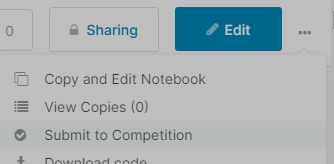

关于Submission Scoring Error的问题，本竞赛在https://www.kaggle.com/sohier/quick-sample-submission 有做解答.
如果不是env的问题，在另一个discussion里也有讨论：https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/192124 
针对获取测试集提交结果的方式，我这里有我自己的代码推荐：


In [ ]:
import riiideducation
env = riiideducation.make_env()
iter_test = env.iter_test()

for (sample_test,sample_prediction_df) in iter_test:
    sample_test = sample_test[sample_test['content_type_id'] == 0]
    # 这里做你的处理
    res = model.predict(sample_test)
    sample_prediction_df.answered_correctly = res
    env.predict(sample_prediction_df)